In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})
SaveFigs = False

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
import random

In [2]:
import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util

/home/map/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


Connecting pochen@datajoint.mesoscale-activity-map.org:3306


In [2]:
def ridge_error(x, y, r=0):
    ''' ridge_error(x, y, lambda):
    predicts y [n by m] from x [n by p] by ridge regression. 
    
    Returns:
    * fit error as a frac of variance (scalar), 
    * weight [p by m], 
    * prediction [N by m].
    '''
    
    # append to bottom of matrices to make ridge regression
    n = x.shape[0]
    p = x.shape[1]
    m = y.shape[1]
    x0 = np.block([[x, np.ones([n,1])]])
    x1 = np.block([[x, np.ones([n,1])], [r*np.eye(p), np.zeros([p,1])]])
    y1 = np.block([[y], [np.zeros((p,m))]])
    w, _, _, _ = np.linalg.lstsq(x1, y1, rcond=None)
    y_hat = x0@w
    return np.mean((y-y_hat)**2)/np.var(y), w, y_hat

#ridge_error(np.array([[1],[0]]),np.array([[2],[1]]),1e10)

In [3]:
class Bunch(dict):
    """A subclass of dictionary with an additional dot syntax."""

    def __init__(self, *args, **kwargs):
        super(Bunch, self).__init__(*args, **kwargs)
        self.__dict__ = self

    def copy(self):
        """Return a new Bunch instance which is a copy of the current Bunch instance."""
        return Bunch(super(Bunch, self).copy())

In [4]:
# parameters for noise process with block target
params_B = Bunch(
    T = 200,  # number of trials
    C = 10,  # number of cells
    ex = 0,  # sd of amplitude of exponential components in sources
    exp_tc = 15,  # time constant of the exponentional components
    nx = 0.1,  # amp of colored noise in sources
    tx = 0,  # sd of amplitude of target in sources
    wx = 0,  # sd of white noise in sources
    shift_rate = 2,  # expected number of shifts during the recording, for each cell
    shift_width = 10,  # width of shifts
    target_noise = False,  # if true, target is pink noise series rather than blocks
    target_shift_amp = 1,  # add a random shift component to target, with this amplitude (only if noise)
    signal_f_tc = False,  # filter target with this timecourse before adding to x. False:don't
    bl = 50,  # target block length, if target is blocks
    blrand = 20,  # block length add random between 0 and this
    tau = 5000.0,  # time constant of pink noise (trials)
    noise_nonlin = 1,  # apply this power to the noise signal to make a nonlinear time series. 1 means linear
    blocks_stationary = False  # shift blocks randomly to make them stationary?
)

# with noise target
params_N = Bunch(params_B)
params_N.target_noise = True

#with actual predictability
params_B1 = Bunch(params_B)
params_B1.tx = .1
params_N1 = Bunch(params_N)
params_N1.tx = 1

param_list = (params_B, params_N, params_B1, params_N1)
n_params = len(param_list)

seed = 5
R = 1000  # number of repeats
N = 500  # number of resamples for p value

In [5]:
def make_shift_sequence(T, C, rate, width, pad=1):
    ''' make a timeseries of logistic shifts occuring at poisson times, of +-1 amplitude 
    (T, C): output size. 
    rate: expected number of shifts per cell. 
    width: logistic width
    pad(=1): what multiple of window to subset from (to make stationary)
    '''
    
    long_seq = np.zeros((pad*T, C))
    for c in range(C):
        shift_times = np.random.choice(pad*T, np.random.poisson(rate*pad))
        for t in shift_times:
            sign = np.sign(np.random.rand(1)-.5)
            long_seq[:,c] += 1/(1+np.exp(sign*(np.arange(pad*T)-t)/width))
    return long_seq[T*(pad-1)//2 : T*(pad+1)//2 ]

def make_data(params):
    ''' returns x, y
    x: T by C array of analog signals [pink noise + exponential drift + linear + target]
    y: target signal: binary block or another noise
    '''

    # weights for each cell
    exp_wt = params.ex * np.random.randn(params.C) 
    y_wt = params.tx * np.random.randn(params.C)
    
    # parameters for filtered noise
    alpha = np.exp(-2.0/ params.tau)
    b = np.array([np.sqrt(1-alpha)])
    a = np.array([1, -np.sqrt(alpha)])
    
    # make filtered noise
    x0, _ =  signal.lfilter(b, a, np.random.randn(params.T, params.C), axis=0, zi=np.random.randn(1, params.C)) 
    
    x = params.nx * (x0**params.noise_nonlin) \
        + exp_wt[None, : ] * np.exp(-np.arange(params.T)[: , None]/params.exp_tc) \
        + params.wx * np.random.randn(params.T, params.C) \
        + make_shift_sequence(params.T, params.C, params.shift_rate, params.shift_width)
        
    if params.target_noise:
        y0, _ =  signal.lfilter(b,a, np.random.randn(params.T, 1), axis=0, zi=np.random.randn(1, 1)) 
        y = params.nx*(y0**params.noise_nonlin) \
            + make_shift_sequence(params.T, 1, params.shift_rate, params.shift_width)
    else: 
        # make blocks
        n_block = 1000 # way too many blocks, because we might randomize from it
        block_len = np.random.randint(params.bl, params.bl+params.blrand, n_block)
        flip_times = np.cumsum(block_len)
        y0 = np.cumsum(np.bincount(flip_times, (-1)**np.arange(n_block)))

        if params.blocks_stationary:
            start_point = np.random.randint(len(y0)//2)
            y = y0[start_point: start_point+params.T, None]
        else:
            y = y0[ :params.T, None]
    
    # now add part of target if needed
    if params.signal_f_tc:
        alpha2 = -np.exp(1.0/params.signal_f_tc)
        a2 = np.array([alpha2/(1+alpha2), 1/(1+alpha2)])  
        yf,_ = signal.lfilter([1],a2,y, axis=0, zi=-y[0,None]/alpha2)
        x += y_wt[None,:] * yf
    else:
        x += y_wt[None,:] * y
    
    # scale 0 to 1
    y = (y-y.min(0))/(y.max(0)-y.min(0))
    x = (x-x.min(0))/(x.max(0)-x.min(0))
    
    return x, y

In [6]:
# make data
# exampleData =[]
# for params in paramList:
#     np.random.seed(Seed)
#     exampleData.append(make_data(params))

test_data = []
for i, params in enumerate(param_list):
    np.random.seed(seed)
    test_data.append([])
    for r in range(R):
        test_data[i].append(make_data(params))

In [7]:
print(f'test_data categories: {len(test_data)}')
print(f'test_data repeats per category: {len(test_data[0])}')
print(f'test_data data point x: {test_data[0][0][0].shape}')  # trial by cell
print(f'test_data data point y: {test_data[0][0][1].shape}')

test_data categories: 4
test_data repeats per category: 1000
test_data data point x: (200, 10)
test_data data point y: (200, 1)


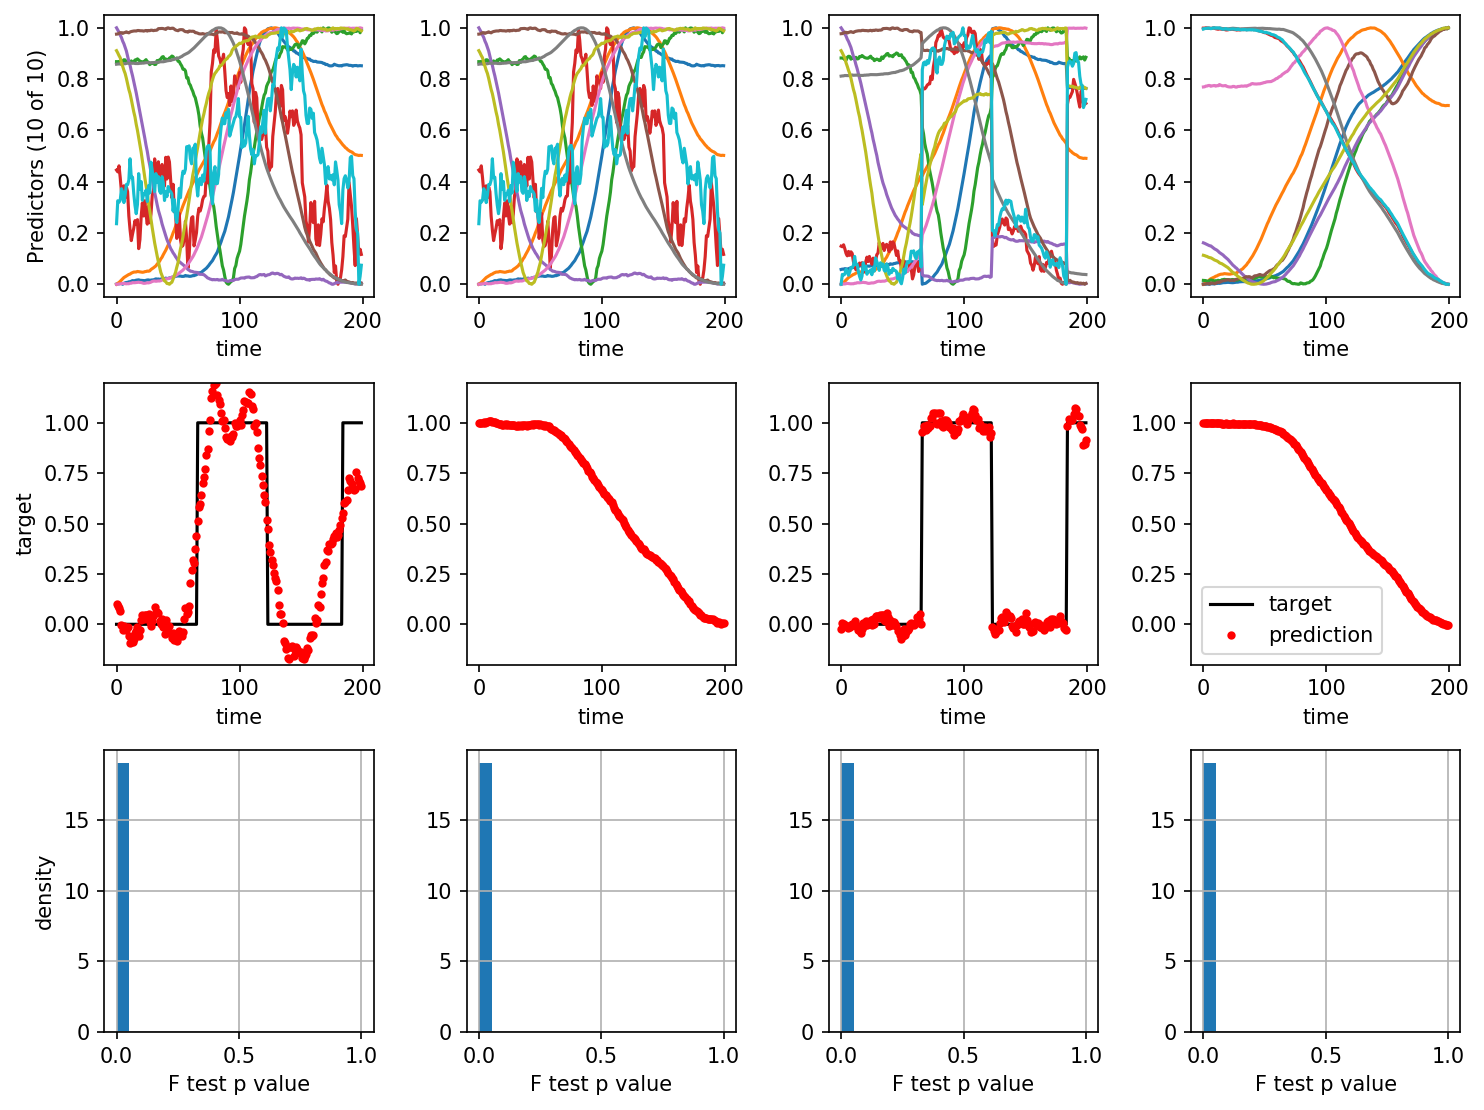

In [8]:
# p values for multiple linear regression

if 1: # make 0 to skip calculations
    p_naive = np.zeros((n_params, R))
    for i in range(n_params):
        for r in range(R):
            x, y = test_data[i][r]
            model = sm.OLS(y,np.hstack((x,np.ones((params.T, 1))))).fit()  # Ordinary Least Squares
            p_naive[i, r] = model.f_pvalue
        
fig, ax = plt.subplots(3, n_params, figsize=(10, 7.5), dpi=150)
for i in range(n_params):
    x, y = test_data[i][0]
    ax[0, i].plot(x[:, :])
    ax[1, i].plot(y, 'k')
    _, _, y_hat = ridge_error(x, y)
    ax[1, i].plot(y_hat, 'r.')
    ax[1, i].set_ylim([-.2, 1.2])
    ax[2, i].hist(p_naive[i], np.linspace(0, 1, 20), density=True)

    ax[2, i].grid()
    ax[0, i].set_xlabel('time')
    ax[1, i].set_xlabel('time')
    ax[2, i].set_xlabel('F test p value')
    
ax[0, 0].set_ylabel(f'Predictors (10 of {params.C})')
ax[1, 0].set_ylabel('target')
ax[2, 0].set_ylabel('density')
ax[1, 3].legend(('target', 'prediction'))

plt.tight_layout()
if SaveFigs: 
    plt.savefig('Ftest.png', dpi=300)

p_value = 0.762
p_value = 0.7979999999999999
p_value = 0.0
p_value = 0.522


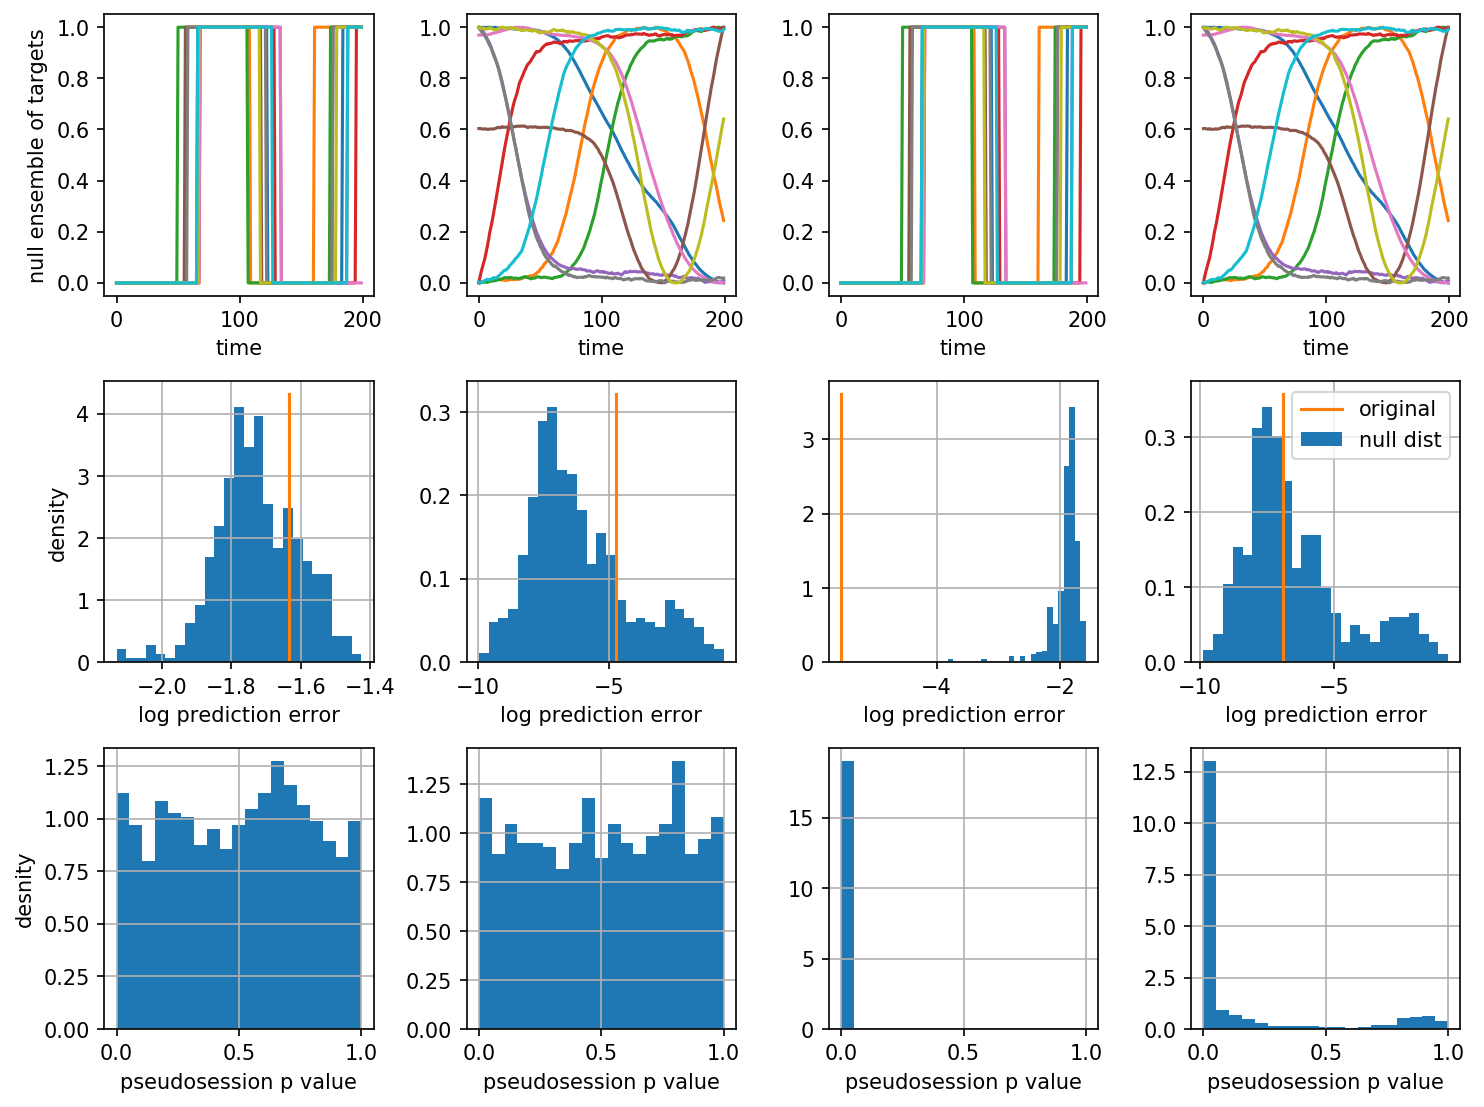

In [9]:
# pseudosession method

if 1: # make 0 to skip calculations
    p_pseudosession = np.zeros((n_params, R))
    pScore_pseud = np.zeros((n_params, N))
    uScore_pseud = np.zeros(n_params)
    for i, params in enumerate(param_list):
        np.random.seed(seed)
        for r in range(R):
            x, y = test_data[i][r]
            uScore_pseud[i], _, _ = ridge_error(x, y) # unpermuted score

            for n in range(N):
                _, y2 = make_data(params)
                pScore_pseud[i, n], _, _ = ridge_error(x, y2)
            # compare the percentile rank of uScore_pseud against the pScore_pseud array
            p_pseudosession[i, r] = stats.percentileofscore(pScore_pseud[i], uScore_pseud[i])/100  

fig, ax = plt.subplots(3, n_params, figsize=(10,7.5), dpi=150)#, sharey='row')
for i, params in enumerate(param_list):
    np.random.seed(seed)
    for n in range(10): 
        _, y2 = make_data(params)
        ax[0, i].plot(y2)
    ax[1, i].hist(np.log(pScore_pseud[i]), 25, density=True)
    ax[1, i].plot(np.full(2, np.log(uScore_pseud[i])), ax[1, i].get_ylim())
    ax[1, i].grid()

    print(f'p_value = {p_pseudosession[i, -1]}')
    ax[2, i].hist(p_pseudosession[i], np.linspace(0,1,20), density=True)
    ax[2, i].grid()
    ax[0, i].set_xlabel('time')
    ax[1, i].set_xlabel('log prediction error')
    ax[2, i].set_xlabel('pseudosession p value')
        
ax[0, 0].set_ylabel('null ensemble of targets')
ax[1, 0].set_ylabel('frequency')
ax[1, 0].set_ylabel('density')
ax[2, 0].set_ylabel('desnity')
ax[1, 3].legend(['original', 'null dist'])
    
plt.tight_layout()
if SaveFigs: plt.savefig('Pseudosession.png', dpi=300)

data set 0
data set 1
data set 2
data set 3


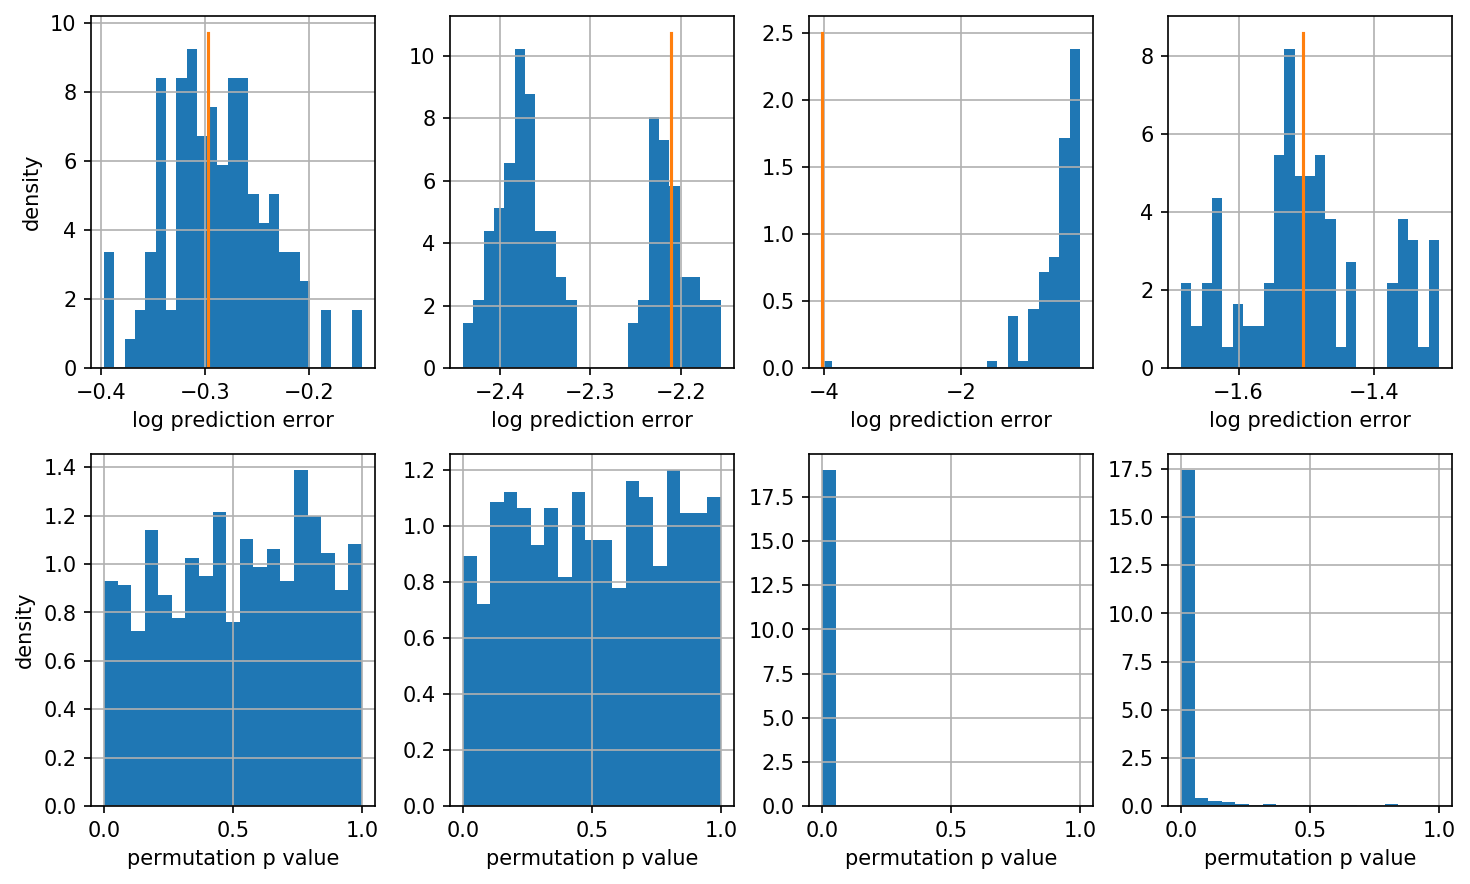

In [10]:
# Session permutation
S = 5 # number of sessions

if 1: # make 0 to skip calculations
    np.random.seed(seed)
        
    p_perm = np.zeros((n_params, R))
    uScore_perm = np.zeros(n_params)
    pScore_perm = np.zeros((n_params, np.math.factorial(S)))

    for i, params in enumerate(param_list):
        print(f'data set {i}')
        for r in range(R):
            x = np.empty(S, dtype=object)
            y = np.empty(S, dtype=object)

            uScore_perm[i] = 0
            for s in range(S):
                x[s], y[s] = make_data(params)
                sc, _, _ = ridge_error(x[s], y[s], 0)
                uScore_perm[i] += sc

            pScore_perm[i] = 0
            for j, p in enumerate(itertools.permutations(range(S))):
                for s in range(S):
                    sc, _, _ = ridge_error(x[s], y[p[s]], 0)
                    pScore_perm[i, j] += sc

            p_perm[i, r] = stats.percentileofscore(pScore_perm[i], uScore_perm[i])/100
        
fig, ax = plt.subplots(2,len(param_list), figsize=(10,6), dpi=150)
for i in range(n_params):
    ax[0, i].hist(np.log(pScore_perm[i]), 25, density=True)
    ax[0, i].plot(np.full(2,np.log(uScore_perm[i])), ax[0,i].get_ylim())
    ax[0, i].grid()
    ax[1, i].hist(p_perm[i],np.linspace(0,1,20), density=True)
    ax[1, i].grid()
    ax[0, i].set_xlabel('log prediction error')
    ax[1, i].set_xlabel('permutation p value')


ax[0, 0].set_ylabel('density')
ax[1, 0].set_ylabel('density')

plt.tight_layout()
if SaveFigs: plt.savefig('SessionPerm.png', dpi=300)

# Simulation

## random walk neurons vs. value from foraging

In [28]:
def gen_random_walk_neuron(n_trial, diff_para=0.1, f_1=2.5, 
                           seed=None, plot=False):
    
    if seed:
        np.random.seed(seed)

    firing_rate = np.zeros(n_trial)
    firing_rate[0] = np.random.uniform(f_1-0.1, f_1+0.1)
    for i in range(1, n_trial):
        firing_rate[i] = max((0, firing_rate[i-1]+np.random.normal(loc=0, scale=diff_para, size=1)))
    
    if plot:
        plt.plot(firing_rate)

    return firing_rate


def gen_action_value_neuron(qs, k_max_modulation=2.35, f_baseline=2.5, 
                            seed=None, plot=False):
    
    if seed:
        np.random.seed(seed)
    
    r_neuron_modulation = np.random.uniform(low=-1.0, high=1.0, size=1)
    firing_rate = f_baseline + k_max_modulation * r_neuron_modulation * qs
    spike_cts = np.random.poisson(lam=firing_rate)
    
    if plot:
        plt.plot(spike_cts)

    return spike_cts

In [88]:
subject_id = 482353
model_id = 6
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable 
                    & {'subject_id': subject_id, 
                       'model_id': model_id})

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)


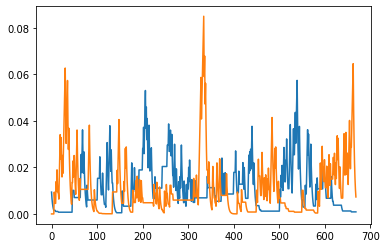

In [89]:
plt.plot(df_Qs[df_Qs['session']==40]['Q_left'].values)
plt.plot(df_Qs[df_Qs['session']==40]['Q_right'].values)

In [90]:
sessions = [38, 39, 40, 42, 45]

n_neurons = 2000
random_walk_fit = {'fr': [], 'params': [], 't_values': []}
action_neuron_fit = {'fr': [], 'params': [], 't_values': []}

for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    X = df_Qs_session[['Q_left', 'Q_right']]
    X = sm.add_constant(X)
    print(f'session {session}: {X.shape}')

    for n in range(n_neurons):
        # random walk neurons
        fr = gen_random_walk_neuron(len(X))
        model = sm.OLS(fr, X)
        results = model.fit()
        random_walk_fit['fr'].append(fr)
        random_walk_fit['params'].append(results.params)
        random_walk_fit['t_values'].append(results.tvalues)
    plt.show()
    plt.close()

    for n in range(n_neurons):
        # action neurons
        q_side = random.choice(['Q_left', 'Q_right'])
        fr = gen_action_value_neuron(X[q_side].values)
        model = sm.OLS(fr, X)
        results = model.fit()
        action_neuron_fit['fr'].append(fr)
        action_neuron_fit['params'].append(results.params)
        action_neuron_fit['t_values'].append(results.tvalues)
    plt.show()
    plt.close()

session 38: (468, 3)
session 39: (594, 3)
session 40: (669, 3)
session 42: (1143, 3)
session 45: (635, 3)


In [91]:
df_t_values_dict = {
    'random_walk': pd.DataFrame(random_walk_fit['t_values']),
    'action_neuron': pd.DataFrame(action_neuron_fit['t_values'])
}

check sum of dots: 10000
10000.0
2599
2175
134
158
check sum of dots: 10000
10000.0
2952
1657
1737
2297


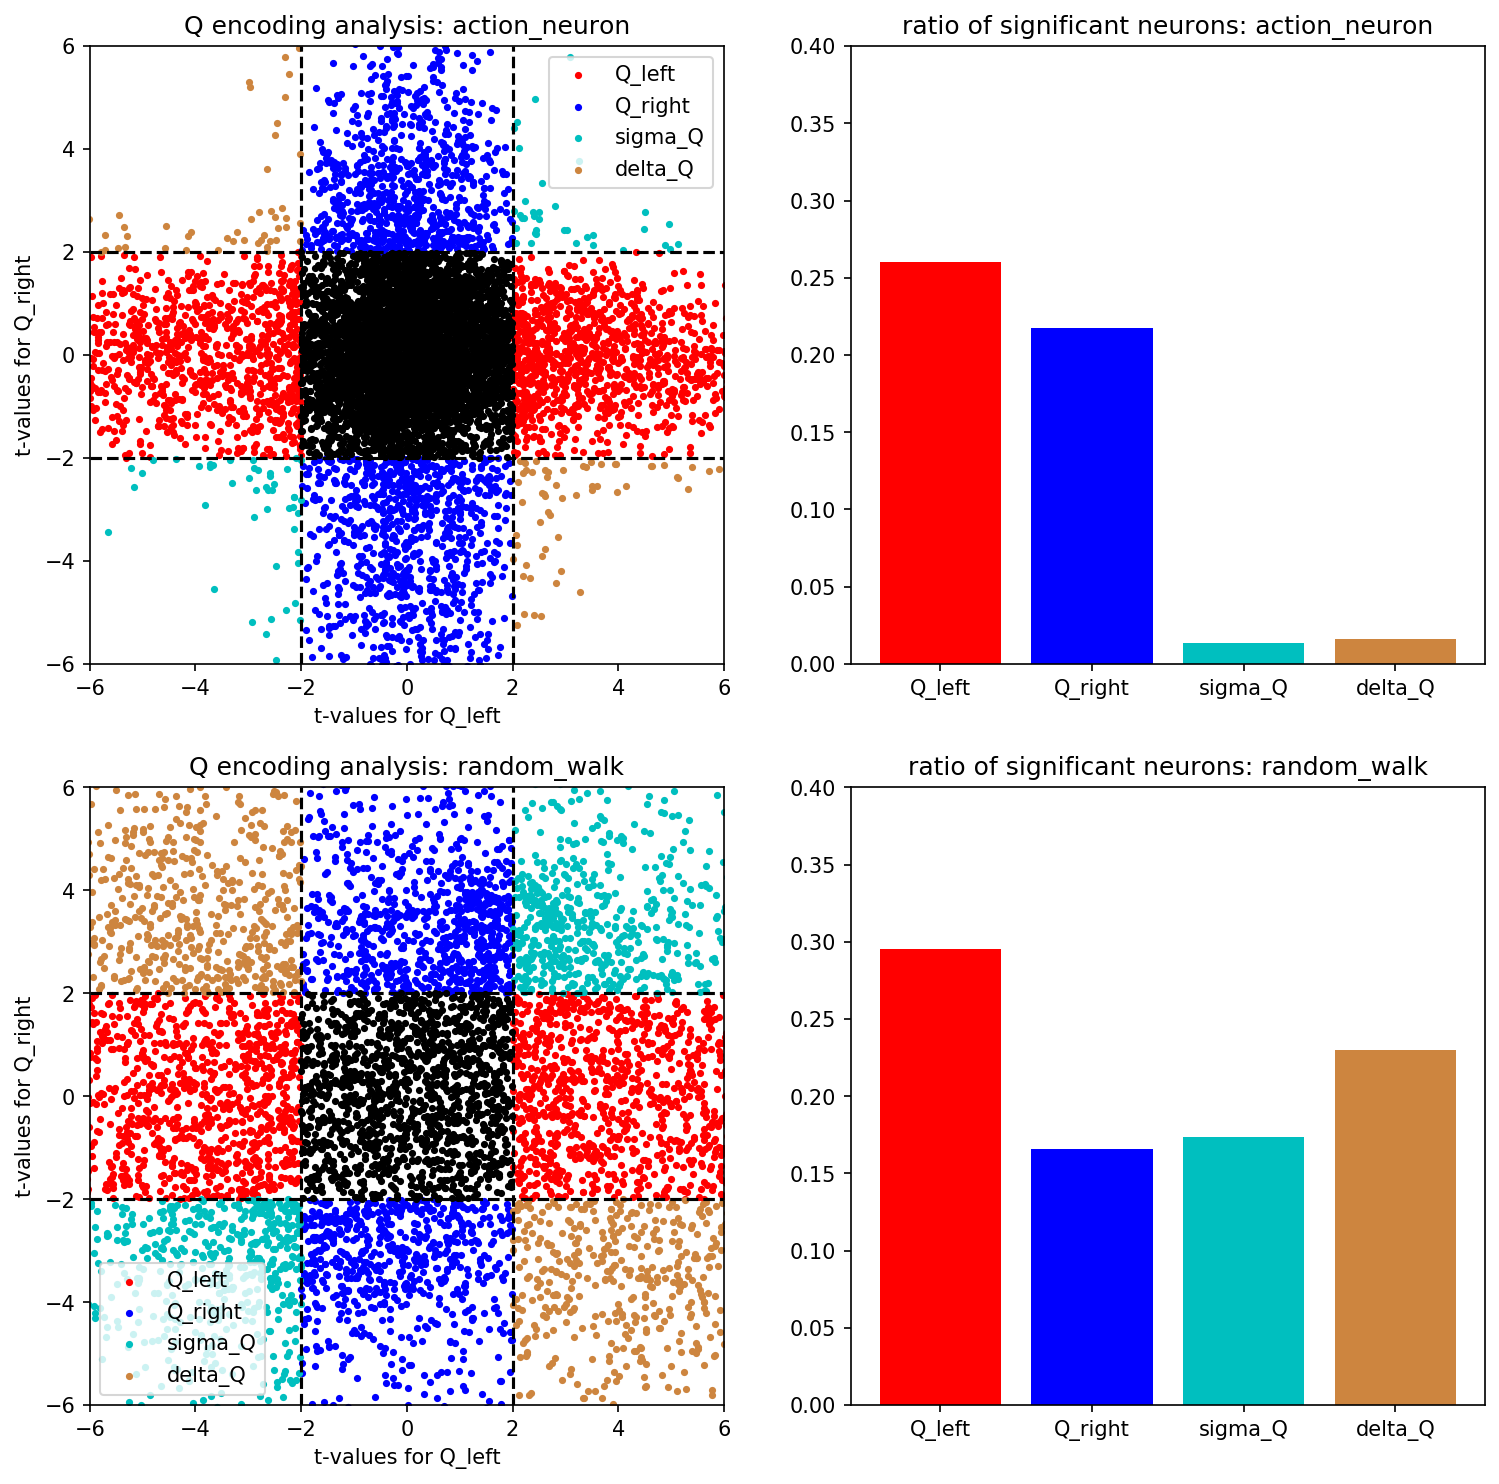

In [92]:
colors = ['r', 'b', 'c', 'peru']
dot_size = 6

neuron_types = ['action_neuron', 'random_walk']

fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=150)
for i, neuron_type in enumerate(neuron_types):
    df_t_values = df_t_values_dict[neuron_type]

    df_t_Q_left = df_t_values[(abs(df_t_values['Q_left'])>=2) & (abs(df_t_values['Q_right'])<2)]
    axs[i, 0].scatter(df_t_Q_left['Q_left'].values, df_t_Q_left['Q_right'].values, 
                      color='r', s=dot_size, label='Q_left')
    df_t_Q_right = df_t_values[(abs(df_t_values['Q_right'])>=2) & (abs(df_t_values['Q_left'])<2)]
    axs[i, 0].scatter(df_t_Q_right['Q_left'].values, df_t_Q_right['Q_right'].values, 
                      color='b', s=dot_size, label='Q_right')
    df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']>=2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']<=-2))]
    axs[i, 0].scatter(df_t_sigma_Q['Q_left'].values, df_t_sigma_Q['Q_right'].values, 
                      color='c', s=dot_size, label='sigma_Q')
    df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']<=-2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']>=2))]
    axs[i, 0].scatter(df_t_delta_Q['Q_left'].values, df_t_delta_Q['Q_right'].values, 
                      color='peru', s=dot_size, label='delta_Q')
    df_t_null = df_t_values[(abs(df_t_values['Q_left'])<2) & (abs(df_t_values['Q_right'])<2)]
    axs[i, 0].scatter(df_t_null['Q_left'].values, df_t_null['Q_right'].values, 
                      color='k', s=dot_size)

    print(f'check sum of dots: {len(df_t_Q_left)+len(df_t_Q_right)+len(df_t_sigma_Q)+len(df_t_delta_Q)+len(df_t_null)}')

    axs[i, 0].axhline(-2, color='k', linestyle='--')
    axs[i, 0].axhline(2, color='k', linestyle='--')
    axs[i, 0].axvline(-2, color='k', linestyle='--')
    axs[i, 0].axvline(2, color='k', linestyle='--')

    axs[i, 0].set_title(f'Q encoding analysis: {neuron_type}')
    axs[i, 0].set_xlim(-6, 6)
    axs[i, 0].set_ylim(-6, 6)
    axs[i, 0].set_xlabel('t-values for Q_left')
    axs[i, 0].set_ylabel('t-values for Q_right')
    axs[i, 0].legend()


    names = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
    print(float(len(df_t_values)))
    print(len(df_t_Q_left))
    print(len(df_t_Q_right))
    print(len(df_t_sigma_Q))
    print(len(df_t_delta_Q))
    values = [
        len(df_t_Q_left)/ float(len(df_t_values)),
        len(df_t_Q_right)/ float(len(df_t_values)),
        len(df_t_sigma_Q)/ float(len(df_t_values)),
        len(df_t_delta_Q)/ float(len(df_t_values))
    ]
    axs[i, 1].bar(names, values, color=colors)
    axs[i, 1].set_title(f'ratio of significant neurons: {neuron_type}')
    axs[i, 1].set_ylim(0, 0.4)


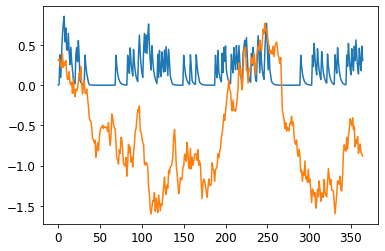

In [151]:
plt.plot(df_Q_left['Q_left'].values)
# plt.plot(df_Q_right['Q_right'].values)
plt.plot(results_dict['fr'][32]/8)

In [93]:
# bootstrp for effect of diffusion parameter
n_neurons = 1000
sessions = [36, 38, 39, 42, 45]
diff_paras = [0, 0.0001, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
diff_para_fit = {}

for diff_para in diff_paras:
    print(f'diffuson parameter: {diff_para}')
    random_walk_fit = {'fr': [], 'params': [], 't_values': []}
    for session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        X = sm.add_constant(X)
        print(f' session {session}: {X.shape}')

        for n in range(n_neurons):
            # random walk neurons
            fr = gen_random_walk_neuron(len(X), diff_para=diff_para)
            model = sm.OLS(fr, X)
            results = model.fit()
            random_walk_fit['fr'].append(fr)
            random_walk_fit['params'].append(results.params)
            random_walk_fit['t_values'].append(results.tvalues)
        plt.show()
        plt.close()
    diff_para_fit[diff_para] = random_walk_fit

diffuson parameter: 0
 session 36: (450, 3)
 session 38: (468, 3)
 session 39: (594, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.0001
 session 36: (450, 3)
 session 38: (468, 3)
 session 39: (594, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.025
 session 36: (450, 3)
 session 38: (468, 3)
 session 39: (594, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.05
 session 36: (450, 3)
 session 38: (468, 3)
 session 39: (594, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.075
 session 36: (450, 3)
 session 38: (468, 3)
 session 39: (594, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.1
 session 36: (450, 3)
 session 38: (468, 3)
 session 39: (594, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.125
 session 36: (450, 3)
 session 38: (468, 3)
 session 39: (594, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.15
 session 36: (450, 3)


In [94]:
ratio_single_significant_values = []
ratio_double_significant_values = []

for diff_para in diff_paras:
    print(f'diff para: {diff_para}')
    df_t_values = pd.DataFrame(diff_para_fit[diff_para]['t_values'])

    df_t_Q_left = df_t_values[(abs(df_t_values['Q_left'])>=2) & (abs(df_t_values['Q_right'])<2)]
    df_t_Q_right = df_t_values[(abs(df_t_values['Q_right'])>=2) & (abs(df_t_values['Q_left'])<2)]
    df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']>=2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']<=-2))]
    df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']<=-2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']>=2))]
    df_t_null = df_t_values[(abs(df_t_values['Q_left'])<2) & (abs(df_t_values['Q_right'])<2)]

    print(f'check sum of dots: {len(df_t_Q_left)+len(df_t_Q_right)+len(df_t_sigma_Q)+len(df_t_delta_Q)+len(df_t_null)}')

    ratio_single_significant_values.append((len(df_t_Q_left)+len(df_t_Q_right))/ float(len(df_t_values)))
    ratio_double_significant_values.append((len(df_t_sigma_Q)+len(df_t_delta_Q))/ float(len(df_t_values)))

diff para: 0
check sum of dots: 4996
diff para: 0.0001
check sum of dots: 5000
diff para: 0.025
check sum of dots: 5000
diff para: 0.05
check sum of dots: 5000
diff para: 0.075
check sum of dots: 5000
diff para: 0.1
check sum of dots: 5000
diff para: 0.125
check sum of dots: 5000
diff para: 0.15
check sum of dots: 5000
diff para: 0.175
check sum of dots: 5000
diff para: 0.2
check sum of dots: 5000


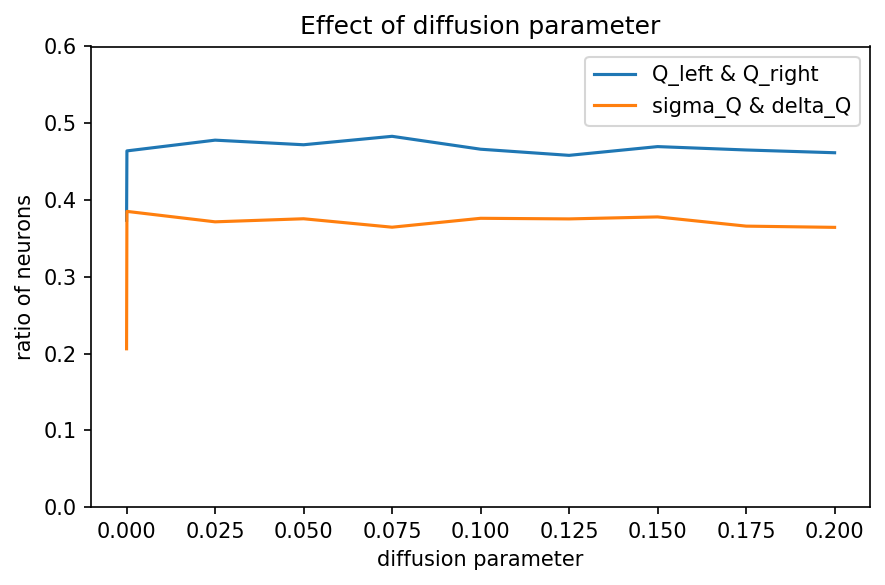

In [95]:
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(diff_paras, ratio_single_significant_values, label='Q_left & Q_right')
plt.plot(diff_paras, ratio_double_significant_values, label='sigma_Q & delta_Q')
plt.title('Effect of diffusion parameter')
plt.ylabel('ratio of neurons')
plt.xlabel('diffusion parameter')
plt.ylim(0, 0.6)
plt.legend()
plt.tight_layout()